# Домашнее задание №3

Задание присылать на почту **aleksartmonov@gmail.com** в форматах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **AU2018 HW3 <Фамилия Имя>**

soft deadline: 18.03.2018T23:59:00+0300

hard deadline: 25.03.2018T23:59:00+0300


### Контуры, фильтрация, морфология

In [1]:
%matplotlib inline

import os
import cv2
import random
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.cluster.hierarchy as hcluster

from itertools import combinations

In [2]:
def show(images, size=7):
    def expand():
        if isinstance(images, (np.ndarray, tuple)):
            return [[images]]
        elif isinstance(images[0], (np.ndarray, tuple)):
            return [images]
        else:
            return images
    
    def plot(ax, img):
        if isinstance(img, tuple):
            img, name = img
        else:
            name = ''
        ax.set_title(name)
        ax.set_axis_off()
        if len(img.shape) == 3:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            if img.dtype == np.complex128:
                ax.imshow(np.abs(img), norm=LogNorm(), cmap='gray')
            else:
                ax.imshow(img, cmap='gray')
    
    images = expand()
    nrows, ncols = len(images), max(len(row) for row in images)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(ncols * size, nrows * size), squeeze=False)
    
    for axes_row, imgs_row in zip(axes, images):
        for ax, img in zip(axes_row, imgs_row):
            plot(ax, img)

**1. (5 баллов)** Выделите в изображении $table.jpg$ границы таблицы с использованием морфологических операций. Результатом обработки должно быть изображение, в котором удален весь текст и оставлены только границы таблицы

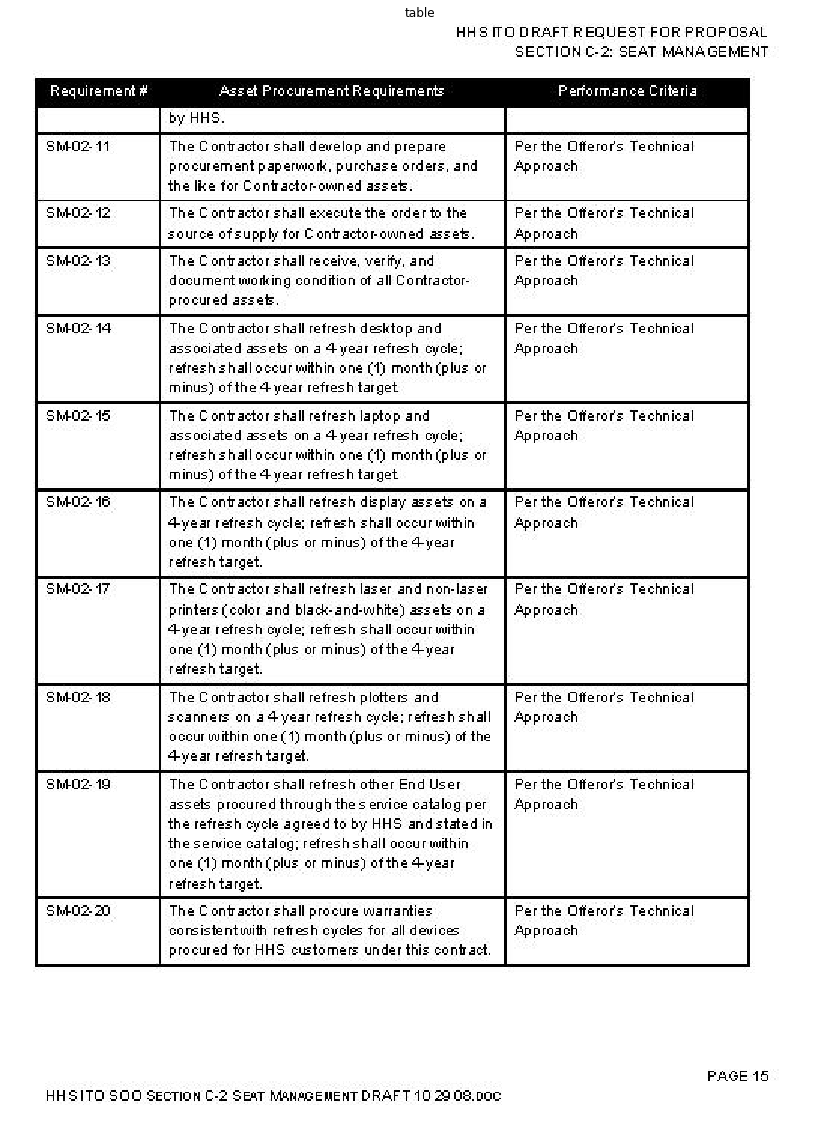

In [3]:
table = cv2.imread('table.jpg')
show((table, 'table'), size=20)

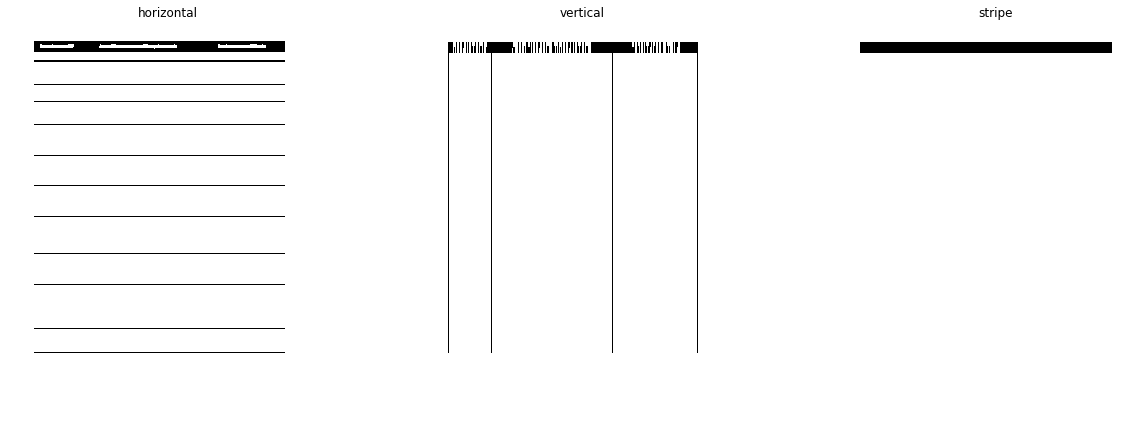

In [4]:
_, table_bw = cv2.threshold(table, 127, 255, cv2.THRESH_BINARY)
image_h = cv2.morphologyEx(table_bw, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1)))
image_v = cv2.morphologyEx(table_bw, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10)))
image_s = cv2.morphologyEx(table_bw, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
image_s = cv2.morphologyEx(image_s, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6)))
show([(image_h, 'horizontal'), (image_v, 'vertical'), (image_s, 'stripe')])

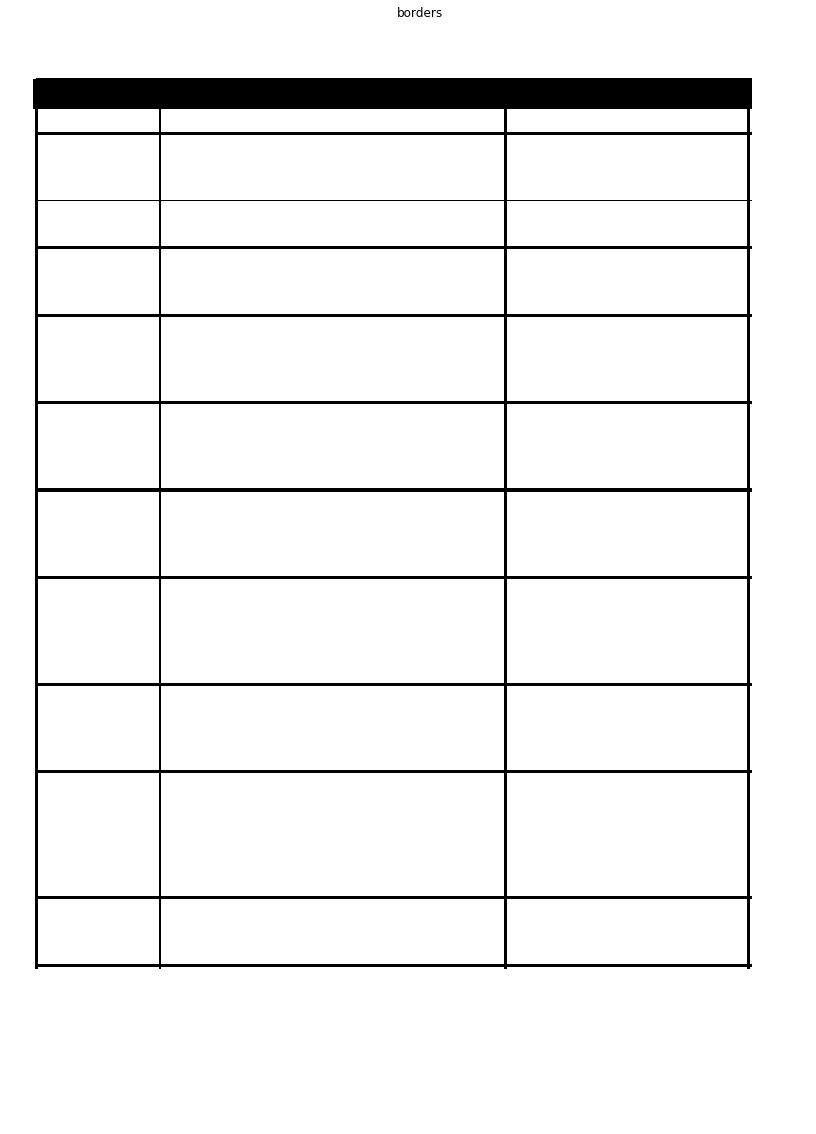

In [5]:
show((image_h & image_v & image_s, 'borders'), size=20)

**2. (5 баллов) ** Отделите монеты от фона на изображении $coins\_1.jpg$, отсортируйте монеты по убыванию размера. Сгенерируйте результирующее изображение с цветной разметкой областей, соответствующих монетам на исходном изображении: на черном фоне должны быть выделены разными цветами области, соответствующие монетам. В центре каждой выделенной области разместите порядковый номер монеты в соответствии с сортировкой монет по размеру (в центре области, соответствующей самой большой монете, должно стоять число 1)

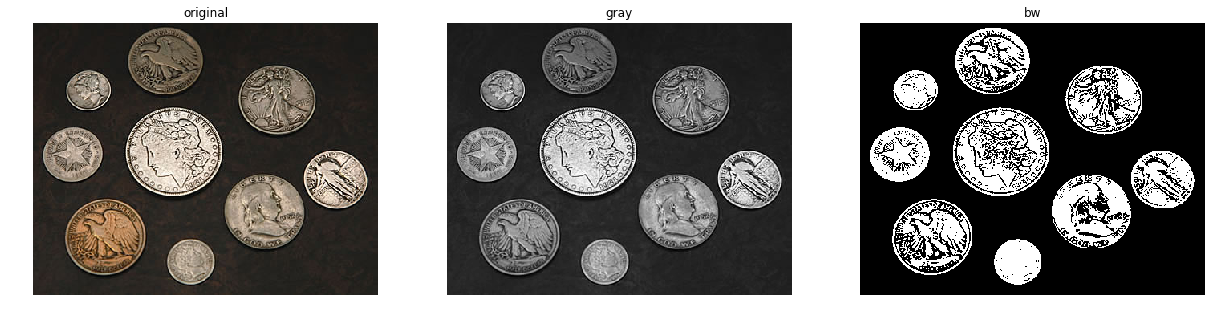

In [6]:
coins_1 = cv2.imread("coins_1.jpg")
coins_1_gray = cv2.cvtColor(coins_1, cv2.COLOR_BGR2GRAY)
coins_1_bw = cv2.adaptiveThreshold(coins_1_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 71, -15)
show([(coins_1, 'original'), (coins_1_gray, 'gray'), (coins_1_bw, 'bw')])

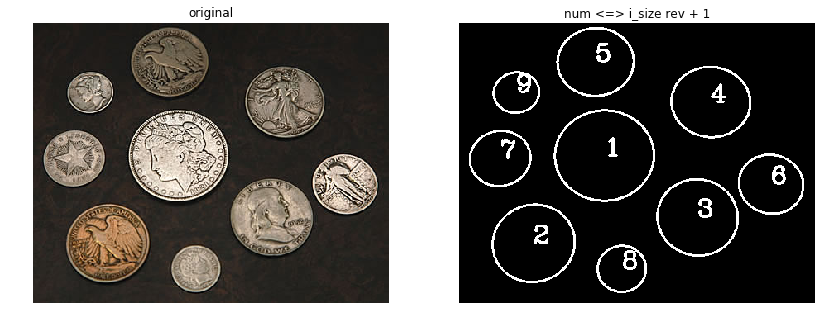

In [7]:
_, contours, _ = cv2.findContours(coins_1_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
big_contours = sorted([c for c in contours if cv2.contourArea(c) > 2000], 
                      key=cv2.contourArea, reverse=True)
coins_1_cnt = np.zeros_like(coins_1_bw)
for i, c in enumerate(big_contours, 1):
    ellipse = cv2.fitEllipse(c)
    coins_1_cnt = cv2.ellipse(coins_1_cnt, ellipse, 255, 2)
    coins_1_cnt = cv2.putText(coins_1_cnt, str(i), (int(ellipse[0][0]), int(ellipse[0][1])), 3, 1, 255, 2)
show([(coins_1, 'original'), (coins_1_cnt, 'num <=> i_size rev + 1')])

**3. (5 баллов)** Отделите монеты от текста на изображении $coins\_2.jpg.$ Сгене- рируйте по входному изображению два изображения: на одном должны остаться только монеты, весь текст должен быть удален; на втором изображении должен остаться только текст, все монеты должны быть удалены.

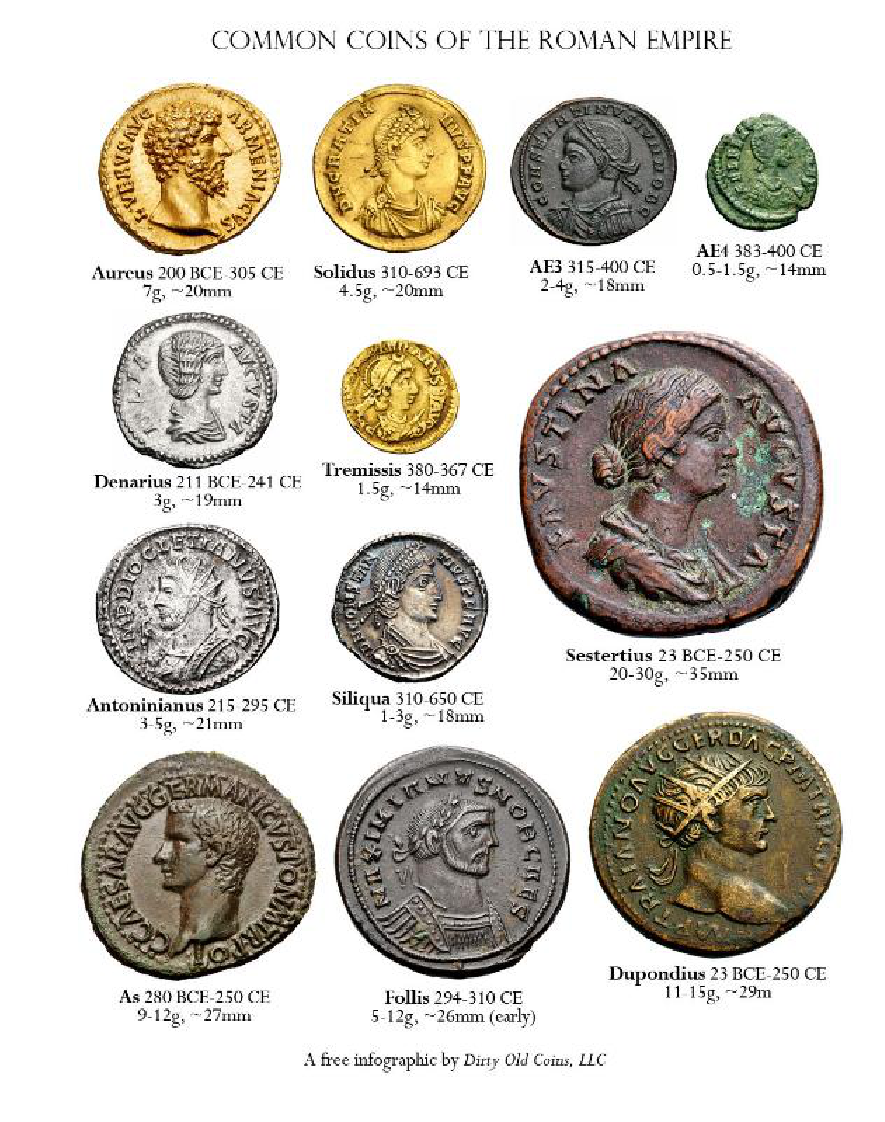

In [8]:
coins_2 = cv2.imread("coins_2.jpg")
show(coins_2, size=20)

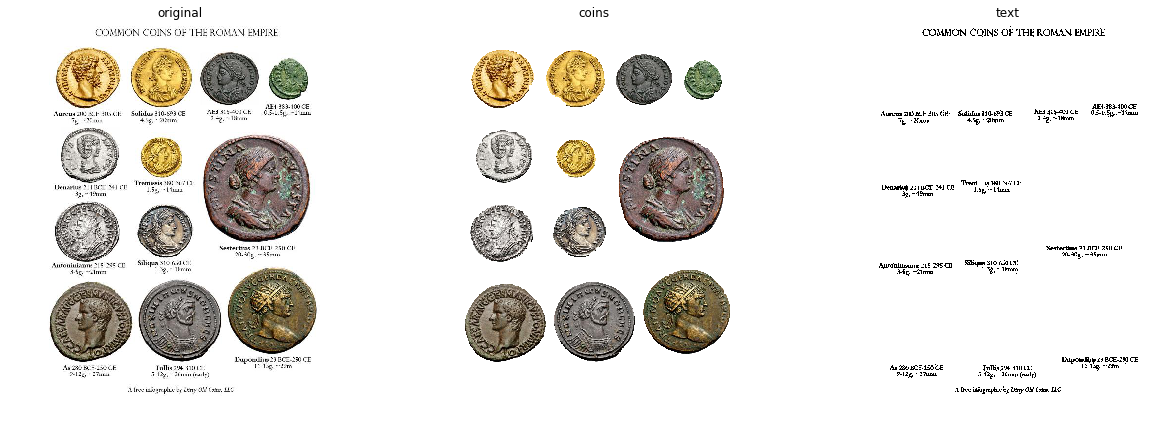

In [9]:
coins_2_bw = cv2.threshold(cv2.cvtColor(coins_2, cv2.COLOR_BGR2GRAY), 230, 255, cv2.THRESH_BINARY)[1]

# coins itself
coins_2_m = cv2.morphologyEx(coins_2_bw, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 4)))
coins_2_m = ~cv2.morphologyEx(coins_2_m, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (12, 18)))
coins_2_m = cv2.erode(coins_2_m, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
coins_2_m = cv2.cvtColor(coins_2_m, cv2.COLOR_GRAY2BGR)
coins_2_a = (coins_2_m & coins_2) | ~coins_2_m

# text
coins_2_m = cv2.dilate(coins_2_m, cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)))
coint_2_b = ~((cv2.cvtColor(coins_2_bw, cv2.COLOR_GRAY2BGR) & ~coins_2_m) ^ ~coins_2_m)

show([(coins_2, 'original'), (coins_2_a, 'coins'), (coint_2_b, 'text')])

**4. (10 баллов) ** Для каждого из зашумленных изображений $coins\_noize\_1.jpg$, $coins\_noize\_2.jpg$, $coins\_noize\_3.jpg$: выделите целые монеты, сгруппируйте их по размеру и посчитайте число монет в каждой группе. На выходе программа должна выдавать полученное число групп монет, средний размер монеты для каждой группы и число монет в каждой группе, а также изображение, визуализирующее результат. На данном изображении на черном фоне должны быть цветом выделены области, соответствующие монетам. Монеты, принадлежащие одной группе, должны быть обозначены одним и тем же цветом. 

Это творческое задание, можно использовать функции типа *HoughCircles, fitEllipse* и тд. 

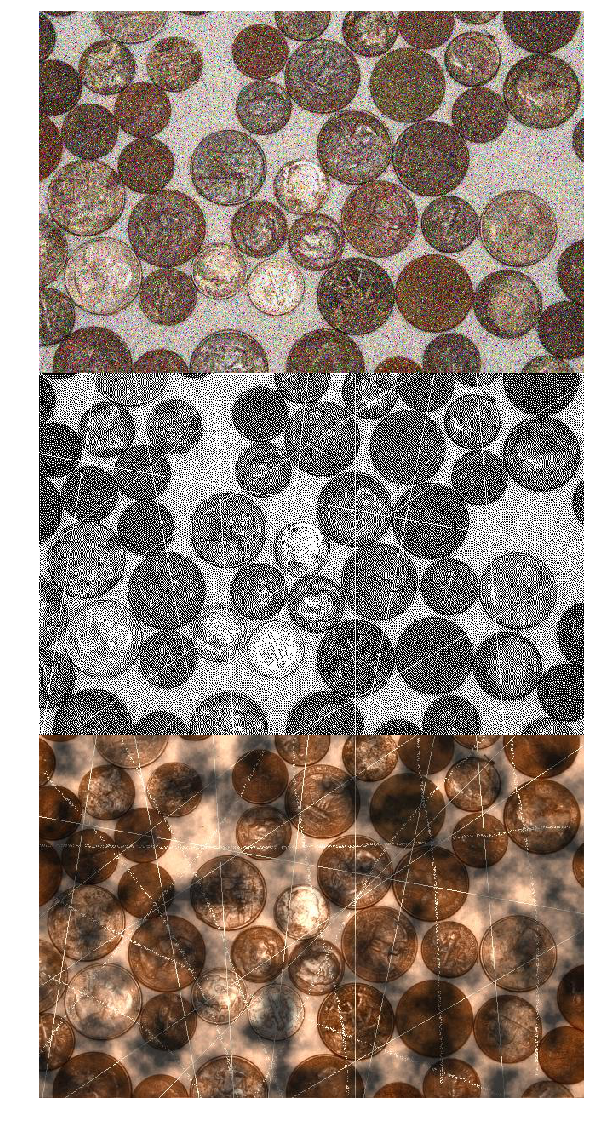

In [10]:
noise_coins = [cv2.imread(x) for x in ["coins_noize_1.jpg","coins_noize_2.jpg","coins_noize_3.jpg"]]
show(np.vstack(noise_coins), size=20)

In [11]:
def show_circles(image, circles, d_threshold=1):
    def is_inside(circle, image):
        (x, y, r), (my, mx, *_) = circle, image.shape 
        return 0 <= x - r <= mx - 2 * r and 0 <= y - r <= my - 2 * r
    
    def color_linspace(n):
        def to_nrgb(prgb):
            return tuple(np.round(255 * np.array(prgb)).astype(int).tolist())
        
        return [to_nrgb(c) for c in sns.color_palette(n_colors=n)]

    # `df`
    circles = [circle for circle in circles if is_inside(circle, image)]
    cdf = pd.DataFrame(circles, columns=['x', 'y', 'radius'])
    del circles
    
    # Calculating info
    cdf['label'] = hcluster.fclusterdata(cdf[['radius']].as_matrix(), d_threshold, criterion='distance') - 1
    n_groups = len(cdf.label.unique())
    colors = color_linspace(n_groups)
    
    average_radiuses = cdf.groupby('label')['radius'].mean().as_matrix()
    n_ingroup = cdf.groupby('label').count().iloc[:, 0].as_matrix()
    
    sc_image = np.zeros_like(image, dtype=np.uint8)
    for _, (x, y, radius, label) in cdf.iterrows():
        cv2.circle(sc_image, (x, y), radius, colors[label], 5)
    
    print(f'n_groups={n_groups} \naverage_radiuses={average_radiuses} \nn_ingroup={n_ingroup}')
    
    show([(image, 'original'), (sc_image, f'show coins (d_threshold={d_threshold})')])

n_groups=3 
average_radiuses=[32.1875 40.5    46.    ] 
n_ingroup=[16  2 12]


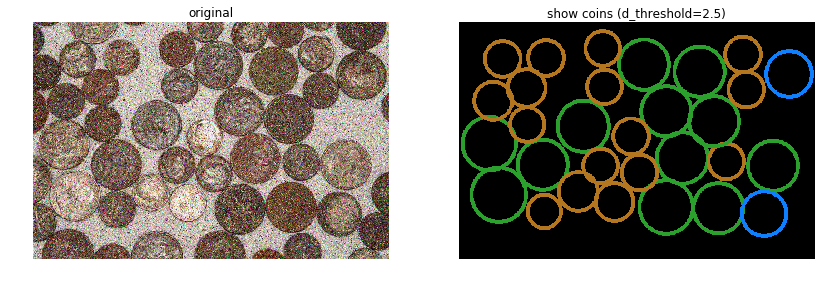

In [12]:
image = noise_coins[0]
image_dn = cv2.cvtColor(cv2.fastNlMeansDenoisingColored(image, h=20), cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(image_dn, cv2.HOUGH_GRADIENT, 1.40, 60, param1=160, param2=35, minRadius=30, maxRadius=50)
circles = np.round(circles[0, :]).astype(int)
show_circles(image, circles, 2.5)

n_groups=3 
average_radiuses=[33.5625     49.         44.72727273] 
n_ingroup=[16  3 11]


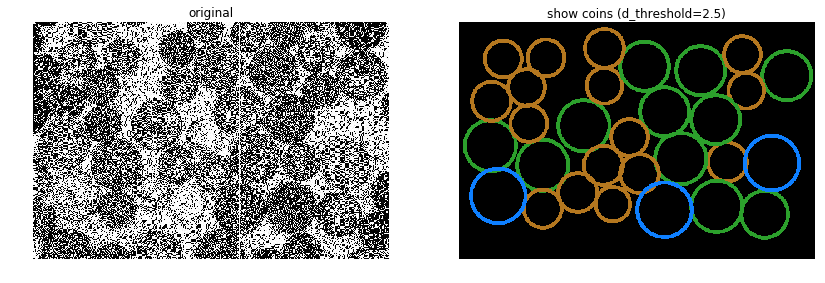

In [13]:
image = noise_coins[1]
image_dn = cv2.cvtColor(cv2.GaussianBlur(image, (7, 7), 0), cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(image_dn, cv2.HOUGH_GRADIENT, 2.1, 60, param1=220, param2=25, minRadius=30, maxRadius=50)
circles = np.round(circles[0, :]).astype(int)
show_circles(image, circles, 2.5)

n_groups=2 
average_radiuses=[44.46153846 33.35294118] 
n_ingroup=[13 17]


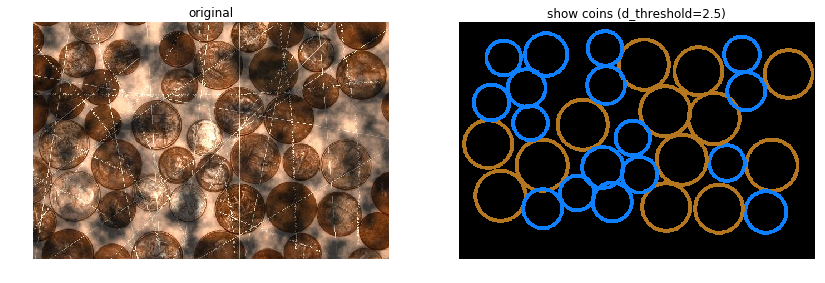

In [14]:
image = noise_coins[2]
image_dn = cv2.cvtColor(cv2.fastNlMeansDenoisingColored(image, h=7), cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(image_dn, cv2.HOUGH_GRADIENT, 1.40, 60, param1=160, param2=35, minRadius=30, maxRadius=50)
circles = np.round(circles[0, :]).astype(int)
show_circles(image, circles, 2.5)

### Сравнение глобальных признаков 

Для задач 5 и 6 надо реализовать общую функцию, которая принимет на вход:

* список дескрипторов (**id**, и сам дескриптор) 
* количество максимально похожих для вывода **n**
* функцию сранения дескрипторов

и отдает **n** пар **id** максимально похожих изображений.

In [15]:
def find_nearest_pairs(images, n, comparator):
    pairs = [(comparator(i1, i2), i1, i2) for i1, i2 in combinations(images, 2)]
    return [(i1, i2) for _, i1, i2 in sorted(pairs, key=lambda _: _[0])[:n]]

**5. (10 баллов)** Посмотрите на изображения в папке *Corel*. Посчитайте гистограммы изображений. Выведите на экран 20 пар изображений с максимально похожими гистограммами. В этом задании надо попробовать:
* различные цветовые пространства (RGB, HSV, CIELab)
* различные способы разбиения на бины (разное количество для каждой характеристики)
* различные метрики сравнения $L_2$, $\chi^2$, пересечение гистограм

In [16]:
def calc_hist(image):
    return cv2.calcHist([image], [0, 1, 2], None, histSize=[20, 20, 20], ranges=[0, 256, 0, 256, 0, 256])

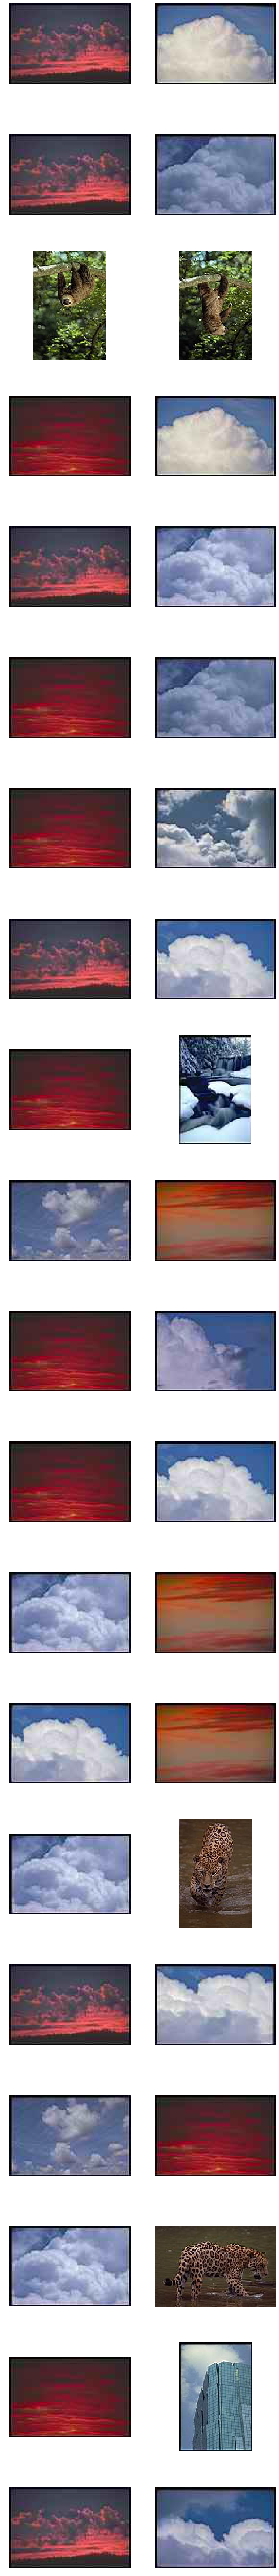

In [17]:
# Read
corals_path = 'datasets/Corel'
corals = [cv2.imread(os.path.join(corals_path, file)) for file in os.listdir(corals_path)]
corals = [cv2.cvtColor(coral, cv2.COLOR_BGR2RGB) for coral in corals]

# Find pairs
comparator = lambda x, y: cv2.compareHist(calc_hist(x), calc_hist(y), cv2.HISTCMP_CHISQR)
pairs = [[cv2.cvtColor(i1, cv2.COLOR_RGB2BGR), cv2.cvtColor(i2, cv2.COLOR_RGB2BGR)] 
         for i1, i2 in find_nearest_pairs(corals, 20, comparator)]

show(pairs)

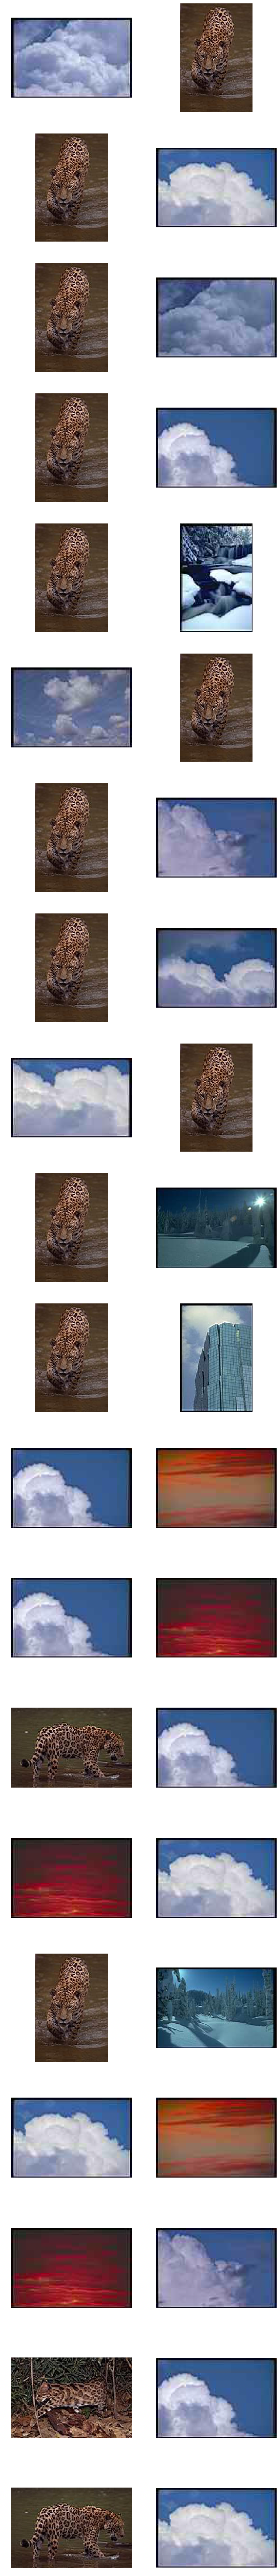

In [18]:
comparator = lambda x, y: cv2.compareHist(calc_hist(x), calc_hist(y), cv2.HISTCMP_INTERSECT)
pairs = [[cv2.cvtColor(i1, cv2.COLOR_RGB2BGR), cv2.cvtColor(i2, cv2.COLOR_RGB2BGR)] 
         for i1, i2 in find_nearest_pairs(corals, 20, comparator)]

show(pairs)

**6. (10 баллов)** Посмотрите на изображения в папке *leaves*. Посчитайте дескрипторы Фурье для каждого листочка изображений. Выведите на экран 20 пар изображений с максимально похожими дескрипторами.

In [19]:
def truncate_descriptor(descriptors, degree):
    """this function truncates an unshifted fourier descriptor array
    and returns one also unshifted"""
    descriptors = np.fft.fftshift(descriptors)
    center_index = len(descriptors) // 2
    descriptors = descriptors[
        center_index - degree // 2:center_index + degree // 2]
    descriptors = np.fft.ifftshift(descriptors)
    return descriptors


def find_descriptor(img):
    """ findDescriptor(img) finds and returns the
    Fourier-Descriptor of the image contour"""
    _, img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY_INV)
    contour = []
    _, contour, hierarchy = cv2.findContours(
        img,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE,
        contour)
    contour_array = contour[0][:, 0, :]
    contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]
    fourier_result = np.fft.fft(contour_complex)
    return truncate_descriptor(fourier_result, 20)

In [20]:
def cmp_v(v1, v2):
    n = min(len(v1), len(v2))
    return np.sum(np.abs((v1[:n] - v2[:n]) ** 2))

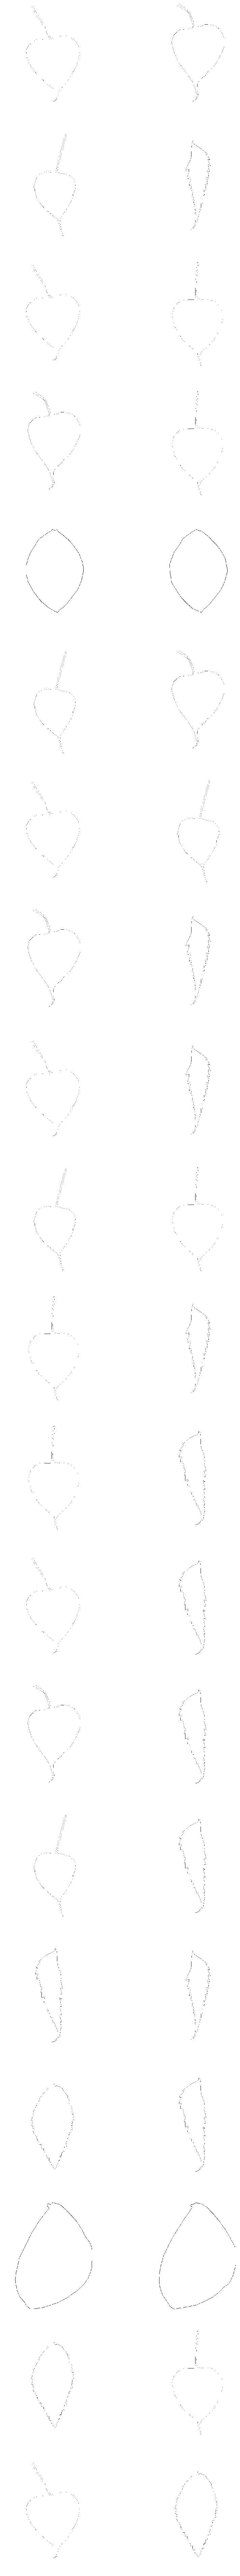

In [21]:
# Read
leaves_path = 'datasets/leaves'
leaves = [cv2.imread(os.path.join(leaves_path, file)) for file in os.listdir(leaves_path)]

# Find pairs
leaves_w_descs = [(find_descriptor(leave), leave) for leave in leaves]
comparator = lambda p1, p2: cmp_v(p1[0], p2[0])
pairs = [[i1, i2] for (d1, i1), (d2, i2) in find_nearest_pairs(leaves_w_descs, 20, comparator)]

show(pairs)